<a href="https://colab.research.google.com/github/jbrown544/interlingual-topic-modeling/blob/main/Interlingual_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Built with spaCy](https://img.shields.io/badge/built%20with-spaCy-09a3d5.svg)](https://spacy.io)

# Unsupervised Thematic Discovery in Non-English Natural Language Corpora

**Note: Use the "Open in Colab" link above to render visualizations. The "Table of contents" side panel in Google Colab is very beneficial for navigating the organization in this notebook.*

## Processing Environment Initialization

In [ ]:
# reduce warnings output

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Environment

In Environment, we create the needed file system entries and initialize useful global variables.

In [ ]:
# configuration folders

# restore ephemeral configuration files in these folders
%mkdir --parents caches keys

In [ ]:
# set environment variable to point to your own service account key

%set_env GOOGLE_APPLICATION_CREDENTIALS=keys/interlingual-topic-modeling.json

env: GOOGLE_APPLICATION_CREDENTIALS=keys/interlingual-topic-modeling.json


In [ ]:
# debugging flag for diagnostic outputs

DEBUG = True

In [ ]:
# random seeding value

random_seed = 42

### Packages

In Packages, we use pip to install the necessary packages and verify package information.

In [ ]:
# update required dependencies

# If you see a message such as this after running pip (bottom of output):
#
# "WARNING: The following packages were previously imported in this runtime:""
# " [ xxxx, xxxxx ]"
# "You must restart the runtime in order to use newly installed versions.""
#
# Please restart the Python runtime. Neglecting this restart may 
# result in errors during processing due to previously loaded packages.

%pip install -U python-Levenshtein \
                spacy \
                pyLDAvis \
                gensim \
                smart_open

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# needed when not executing in Google Colab

%pip install google-cloud-translate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# inspect spaCy package information

%pip show spacy

Name: spacy
Version: 3.1.3
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /opt/conda/lib/python3.9/site-packages
Requires: typer, thinc, requests, cymem, spacy-legacy, srsly, packaging, tqdm, murmurhash, blis, pathy, numpy, jinja2, catalogue, pydantic, preshed, setuptools, wasabi
Required-by: pl-core-news-sm, pl-core-news-md, pl-core-news-lg, fr-core-news-sm, fr-core-news-md, fr-core-news-lg, es-core-news-sm, es-core-news-md, es-core-news-lg, en-core-web-sm, en-core-web-md, en-core-web-lg
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# inspect pyLDAvis package information

%pip show pyLDAvis

Name: pyLDAvis
Version: 3.3.1
Summary: Interactive topic model visualization. Port of the R package.
Home-page: https://github.com/bmabey/pyLDAvis
Author: Ben Mabey
Author-email: ben@benmabey.com
License: MIT
Location: /opt/conda/lib/python3.9/site-packages
Requires: scikit-learn, gensim, numpy, joblib, scipy, jinja2, setuptools, funcy, future, numexpr, pandas, sklearn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# inspect Gensim package information

%pip show gensim

Name: gensim
Version: 4.1.2
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /opt/conda/lib/python3.9/site-packages
Requires: smart-open, scipy, numpy
Required-by: pyLDAvis
Note: you may need to restart the kernel to use updated packages.


## Data Environment Initialization

### Dependencies

In Dependencies, we import various tools and interrogate the system for available resources.

In [ ]:
# dependencies

import json
from urllib.parse import urljoin
from os.path import exists
from collections import Counter
import multiprocessing
import math

from google.cloud import translate_v2 as translate

import matplotlib.pyplot as plt 

import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.test.utils import get_tmpfile

from smart_open import open

/opt/conda/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
# enable visualizations inline

pyLDAvis.enable_notebook()

In [ ]:
# determine this instance's available cpu cores

cores = max(multiprocessing.cpu_count() - 1, 1)

print(f'{cores} core(s) available')

5 core(s) available


### Translation Tools

#### Translation Caching

These Translation Caching functions handle cache persistence and extend the cache with new translation entries by accessing a cloud translation service.

In [ ]:
# file to persist cached translation dictionaries

xlat_cache_file_name = 'caches/xlat.json'

In [ ]:
# translation cache: loading

def load_translation_cache():  
  """ 
  Return a translation cache populated with previously persisted dictionaries.
  """
  
  xlat_cache = {}

  # if it exists, load the cache
  if exists(xlat_cache_file_name):
    with open(xlat_cache_file_name) as f:
        xlat_cache = json.load(f)

    if DEBUG:
      print(f'"{xlat_cache_file_name}" xlat cache loaded:')
      for lang in xlat_cache:
        print(f'\t[{lang}] contains {len(xlat_cache[lang])} entries')

  return xlat_cache

In [ ]:
# translation cache: saving

def save_translation_cache(dirty_xlat_cache):
  """
  Save a translation cache overwriting any previously persisted dictionaries.

  Keyword arguments:
      dirty_xlat_cache -- a dirty translation cache
  """

  with open(xlat_cache_file_name, 'w') as f:
    json.dump(dirty_xlat_cache, f)

  if DEBUG:
    print(f'"{xlat_cache_file_name}" xlat cache persisted.',
          'Please make a non-ephemeral copy!!!')

In [ ]:
# translation cache: extending

def extend_translation_cache(terms,
                             source_language,
                             target_language='en'):  
  """
  Extend a translation cache resolving any unknown terms using a cloud 
  translator. Return the number of cache misses and the translation dictionary 
  for the specified source language containing at least the requested terms.

  Keyword arguments:
      terms -- sequence of terms to warm in cache
      source_language -- the language of terms
      target_language -- the target language for term translation
  """

  # get the persisted cache
  xlat_cache = load_translation_cache()

  # get or create a dictionary for the specified language mapping
  xlat_dict = xlat_cache.setdefault(f'{source_language}->{target_language}', {})

  cache_terms = [term for term in terms if term not in xlat_dict]

  # if there are unknown terms, resolve them with cloud translation
  if len(cache_terms) > 0:

    print(f'Translating {len(cache_terms)} terms.')

    translate_client = translate.Client(target_language=target_language)

    # the cloud translation API processes lists of a finite length so
    # terms requiring resolution are batched into 128 per invocation
    batch_size = 128

    # process terms in batches storing results into the translation dictionary
    for i in range(0, len(cache_terms), batch_size):
      for result in translate_client.translate(cache_terms[i:i+batch_size],
                                               source_language=source_language):
        xlat_dict[result['input']] = result['translatedText']
    
    # overwrite the persisted cache
    save_translation_cache(xlat_cache)

  return len(cache_terms), xlat_dict

#### Gensim Dictionary Translation

These Gensim Dictionary Translation functions augment a Gensim Dictionary with translated terms contained in the translation cache. To augment a dictionary, the source dictionary is first persisted to a temporary file then the file is augmented. A new Gensim Dictionary may then be constructed using the altered temporary file.

In [ ]:
# gensim dictionary: loading

def load_gensim_dictionary_file(dict_file):
  """
  Load the entries of a gensim dictionary file then return a tuple
  containing read document count and list of entries.

  Keyword arguments:
      dict_file -- gensim dictionary file
  """

  entries = []

  # read structure from file
  with open(dict_file) as f:
    num_docs = f.readline().strip()
    line = f.readline().strip()
    while line != '':
      entries.append(line.split('\t'))
      line = f.readline().strip()

  return num_docs, entries

In [ ]:
# gensim dictionary: saving

def save_gensim_dictionary_file(dict_file, 
                                dict_entries):
  """
  Save the entries of a gensim dictionary to a file.

  Keyword arguments:
      dict_file -- gensim dictionary file
      dict_entries -- list of (id, term, frequency) entries
  """

  # unpack the entries structure
  num_docs, entries = dict_entries

  # write structure to file
  with open(dict_file, 'w') as f:
    f.write(num_docs)
    f.write('\n')
    for entry in entries:
      f.write('\t'.join(map(str, entry)))
      f.write('\n')

In [ ]:
# gensim dictionary: individual entry translation

def translate_gensim_dictionary_entries(dict_entries,
                                        source_language,
                                        target_language='en'):
  """
  Returns the number of translation cache misses and a new list of gensim 
  dictionary entries having terms augmented with translations.

  Keyword arguments:
      dict_entries -- list of (id, term, frequency) entries
      source_language -- the language of entry terms
      target_language -- the target language for entry term translation
  """

  # unpack the entries structure
  num_docs, entries = dict_entries

  # extend the cache with the requested terms
  misses, xlat_dict = \
    extend_translation_cache([term for id, term, freq in entries],
                             source_language, target_language)

  # created augmented dictionary entries
  entries = entries.copy()
  for i in range(len(entries)):
    entries[i][1] = f"{xlat_dict[entries[i][1]]} ({entries[i][1]})"

  return misses, (num_docs, entries)

In [ ]:
# gensim dictionary: dictionary translation

def translate_gensim_dictionary(gensim_dictionary, 
                                source_language,
                                target_language='en'):
  """
  Returns the number of translation cache misses and a new gensim dictionary 
  with entries augmented with their target language translations.

  Keyword arguments:
      gensim_dict_entries -- list of (id, term, frequency) entries
      source_language -- the language of entry terms
      target_language -- the target language for entry term translation
  """

  # convert dictionary to entries structure by way of temp file
  dict_file = get_tmpfile('dict_file')
  gensim_dictionary.save_as_text(dict_file)
  gensim_dict_entries = load_gensim_dictionary_file(dict_file)

  # augment the entries structure with translations
  misses, xlat_entries = translate_gensim_dictionary_entries(
      gensim_dict_entries, source_language, target_language)

  # convert entries structure to dictionary by way of temp file
  xlat_dict_file = get_tmpfile('xlat_dict_file')
  save_gensim_dictionary_file(xlat_dict_file, xlat_entries)  
  return misses, corpora.Dictionary().load_from_text(xlat_dict_file)

#### Translation Test

In Translation Test, we confirm our translation cache is available. Generating translations incurs cost so working from the cache file ensures redundant translations are not performed.

In [ ]:
# test translate a small dictionary

misses, translated_test_dict = \
  translate_gensim_dictionary(corpora.Dictionary([['crayon', 'stylo']]), 'fr')

# Check we have a previously populated dictionary.
# This check helps ensure we are not forgetting 
# to install our ephemeral translation dictionary file.
assert misses == 0

print(translated_test_dict)

"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries
Dictionary(2 unique tokens: ['pencil (crayon)', 'pen (stylo)'])


### Language-Neutral Processing Pipeline

#### Install spaCy Language Models

Here we install spaCy's statistical models for languages of interest. There are many language models available at the time of this writing and appear to be others in development.

In [ ]:
# install data sets required for spaCy statistical models

# the medium models provide better accuracy over small models 
# and less overhead than large models

%run -m spacy download fr_core_news_md
%run -m spacy download es_core_news_md
%run -m spacy download pl_core_news_md
%run -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


#### Basic Preprocessing (Gensim)

This is a basic text preprocessing function used as a comparison benchmark.

In [ ]:
# basic text preprocessing

def basic_preprocess(texts,
                     deaccent=False,
                     min_token_length=2,
                     max_token_length=15):
  """
  Perform basic (faster) preprocessing on a list of texts returning the 
  tokenized results.

  Processing consists of tokenization, lowercasing, filtering tokens to a
  length range and optionally removing accenting marks.

  Keyword arguments:
      texts -- strings containing source texts
      deaccent -- remove accents from characters
      min_token_length -- the minimum token length to retain
      max_token_length -- the maximum token length to retain
  """

  return [simple_preprocess(text, deacc=deaccent,
                     min_len=min_token_length,
                     max_len=max_token_length)
  for text in texts]

#### Advanced Preprocessing (spaCy)

This is the text preprocessing function used to tokenize and filter text for model processing. It employs spaCy's language models to provide standard processing independent of the targeted language.

In [ ]:
# advanced text preprocessing

def advanced_preprocess(nlp, 
                        texts,
                        min_token_length=2,
                        max_token_length=15,
                        processors=1):
  """
  Perform more advanced (slower) preprocessing on a list of texts returning the 
  tokenized results.

  Processing consists of tokenization, lowercasing, filtering tokens to a
  length range, filtering by high-value parts of speech (nouns, verbs, etc.),
  filtering non-alphabetic terms, and filtering language specific stopwords.

  Keyword arguments:
      nlp -- spaCy language model appropriate for texts
      texts -- list of strings containing language texts      
      min_token_length -- the minimum token length to retain
      max_token_length -- the maximum token length to retain
      processors -- count of CPUs to employ; (-1=all) use with caution!
  """

  # SpaCy's NLP processing pipeline extracts 'features' from text
  # useful for selecting the more valuable terms. 
  # Here, only parts-of-speech listed are preserved.
  keep_pos = {'PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV'}
  
  return [[token.lemma_.lower() for token in doc
           if token.pos_ in keep_pos
           and token.is_alpha and not token.is_stop
           and len(token.lemma_) >= min_token_length
           and len(token.lemma_) <= max_token_length]
          for doc in nlp.pipe(texts, n_process=processors)]

### Topic Modeling Utilities

#### Text Exploratory Data Analysis (EDA)

This EDA function gathers a variety of interesting statistics on a corpus. It employs spaCy's statistical language models to assess a collection of useful metrics on sources in any of the supported languages.

In [ ]:
# explore and analyze text corpus

def corpus_eda(nlp, texts,
               target_language='en',
               processors=1):
  """
  Print a report of various EDA statistics on a corpus. 
  
  The corpus can be in any language provided a document model is available 
  to process its contents.

   Keyword arguments:
      nlp -- spaCy language model appropriate for texts
      texts -- list of strings containing language texts
      target_language -- the target language for text translation
      processors -- count of CPUs to employ; (-1=all) use with caution!
  """

  # measures taken
  doc_count = 0
  sent_count = 0
  token_count = 0
  word_count = 0  
  word_pos_counter = Counter()
  word_counter = Counter()
  noun_counter = Counter()
  verb_counter = Counter()

  # enable the fast statistical sentence bounder
  nlp.enable_pipe('senter')

  # iterate documents and aggregate various measures
  for doc in nlp.pipe(texts, n_process=processors):

    doc_count += 1

    for sent in doc.sents:

      sent_count += 1
      token_count += len(sent)
      words = [token for token in sent if token.is_alpha]
      word_count += len(words)
      word_pos_counter.update([word.pos_ for word in words])
      word_counter.update([word.text for word in words])
      noun_counter.update([word.text for word in words 
                           if word.pos_ in {'NOUN', 'PROPN'}])
      verb_counter.update([word.text for word in words 
                           if word.pos_ == 'VERB'])

  # disable sentence bounder
  nlp.disable_pipe('senter')

  # report statistics

  print('EDA Report')
  print('----')
  print(f'Document count: {doc_count:,}')
  print(f'POS count: {len(word_pos_counter):,}')
  print(f'Sentence count: {sent_count:,}')
  print(f'Token count: {token_count:,}')
  print(f'Word count: {word_count:,}')
  print(f'Unique Word count: {len(word_counter):,}')
  
  print('----')
  print(f'Avg. Tokens/Sentence: {round(token_count/sent_count, 2):,}')
  print(f'Avg. Words/Sentence: {round(word_count/sent_count, 2):,}')
  print(f'Avg. Tokens/Document: {round(token_count/doc_count, 2):,}')  
  print(f'Avg. Words/Document: {round(word_count/doc_count, 2):,}')
  print(f'Avg. Sentences/Document: {round(sent_count/doc_count, 2):,}')
  
  print('----')
  
  # plot POS
  plt.xticks(rotation=90)
  pos_counts = sorted(word_pos_counter.items(), 
                      key=lambda x: x[0])
  plt.bar([key for key, _ in pos_counts],
          [pos for _, pos in pos_counts])
  plt.ylabel('Count')
  plt.title("Parts-of-Speech")
  plt.show()
  print('POS Tags: https://universaldependencies.org/docs/u/pos/')

  print('----')

  # gather most common entries
  top_nouns = noun_counter.most_common(25)
  top_verbs = verb_counter.most_common(25)
  top_words = [word for word, _ in top_nouns + top_verbs]

  if nlp.lang != target_language:
    # extend the translation cache with common entries
    misses, xlat_dict = extend_translation_cache(top_words, nlp.lang, 
                                                target_language)

  # plot top nouns
  plt.xticks(rotation=90)
  if nlp.lang != target_language:
    plt.bar([f'{xlat_dict[word]} ({word})' for word, _ in top_nouns],
            [count for _, count in top_nouns])
  else:
    plt.bar([f'{word}' for word, _ in top_nouns],
            [count for _, count in top_nouns])
  plt.ylabel('Count')
  plt.title('Most Common Nouns')
  plt.show()
  
  # plot top verbs
  plt.xticks(rotation=90)
  if nlp.lang != target_language:
    plt.bar([f'{xlat_dict[word]} ({word})' for word, _ in top_verbs],
            [count for _, count in top_verbs])
  else:
    plt.bar([f'{word}' for word, _ in top_verbs],
            [count for _, count in top_verbs])
  plt.ylabel('Count')
  plt.title('Most Common Verbs')
  plt.show()

#### Topic Model Coherence Evaluation

Topic Model Coherence Evaluation is a configurable test routine which exercises a model while evaluating model coherence ratings for the variable under test. At the conclusion of evaluation, the most successful model is returned.

##### Topic Evaluator

This Topic Evaluator is a configurable option for the ```evaluate_coherence()``` function. Instead of creating a coherence model from a model under evaluation, this evaluator extracts topics from the model and provides those to the coherence model. This is useful if a model is not currently supported for evaluation by the ```CoherenceModel()``` in Gensim.

In [ ]:
# evaluator: evaluate topic coherence at a particular value of a test parameter

def evaluate_topics(model_class,
                    model_params,
                    coherence_params,
                    test_param,
                    test_arg,
                    coherence,
                    num_topics=999_999,
                    **kwargs):
  """
  Construct model for specific parameter values returning the coherence results.
  
  This function is called by evaluate_coherence() and internally evaluates
  topics generated by the constructed model.

  Keyword arguments:
      test_arg -- value of test_param
      num_topics -- this is a work-around because the documented -1 does not 
                    include all topics
      ** -- all other arguments are pass-through from evaluate_coherence()
  """

  # setup execution parameters
  execute_params = dict(model_params)
  execute_params[test_param] = test_arg

  # construct test model
  test_model = model_class(**execute_params)
  
  topics = [[term for term, weight in terms] 
            for _, terms in test_model.show_topics(num_topics=num_topics,
                                                   formatted=False)]
                                                  
  # construct coherence model
  test_coherence = models.CoherenceModel(topics=topics,
                                         coherence=coherence,
                                         processes=1,
                                         **coherence_params)
      
  return (test_arg, test_coherence.get_coherence(), test_model)

##### Model Evaluator

This Model Evaluator is a configurable option for the ```evaluate_coherence()``` function. This uses ```CoherenceModel()``` in Gensim to evaluate supported models directly.

In [ ]:
# evaluator: evaluate model coherence at a particular value of a test parameter

def evaluate_model(model_class,
                   model_params,
                   coherence_params,
                   test_param,
                   test_arg,
                   coherence,
                   **kwargs):
  """
  Construct model for specific parameter values returning the coherence results.
  
  This function is called by evaluate_coherence() and internally evaluates the
  constructed model.

  Keyword arguments:
      test_arg -- value of test_param
      ** -- all other arguments are pass-through from evaluate_coherence()
  """

  # setup execution parameters
  execute_params = dict(model_params)
  execute_params[test_param] = test_arg

  # construct test model
  test_model = model_class(**execute_params)

  # construct coherence model
  test_coherence = models.CoherenceModel(model=test_model,
                                         coherence=coherence,
                                         processes=1,
                                         **coherence_params)
      
  return (test_arg, test_coherence.get_coherence(), test_model)

##### Sorting Key Function for Best Evaluation

These Sorting Key Functions are configurations provided to ```evaluate_coherence()``` to determine the highest quality result produced during evaluation. The various configurable metrics possible require differing assessment so these functions allow choosing the best among the test results.

In [ ]:
# sorting key function: best value is lowest

def best_lowest(x):
  """
  Key items by lowest coherence then by lowest test_arg.

  Keyword arguments:
      x -- coherence results tuple to order
  """

  return (x[1], x[0])

In [ ]:
# sorting key function: best value nearest 1

def best_nearest_one(x):
  """
  Key items by coherence nearness to one then by lowest test_arg.

  Keyword arguments:
      x -- coherence results tuple to order
  """

  return (abs(1 - x[1]), x[0])

##### Coherence Evaluation

The Coherence Evaluation function is core to the analysis in this notebook. It is configured with values and parameter maps used to invoke a series of tests on models in search of preferred performers. This is a parameter searching approach simplified here to investigate a single variable. There are many demonstrations of usage later in this notebook. This function attempts to employ as many cores as the processing machine can employ to expedite this time consuming process.

In [ ]:
# coherence evaluation

def evaluate_coherence(model_class,
                       model_params,
                       coherence_params,
                       test_param,
                       test_series,                       
                       evaluation_function=evaluate_model,                       
                       best_key_func=best_lowest,
                       coherence='u_mass',                       
                       processors=1,
                       show_plot=True,
                       **kwargs):
  """
  Perform a generalized coherence evaluation on a model_class returning the 
  optimal value of test_param over test_series.

  Results are plotted showing the optimal value marked on the plot.

  Keyword arguments:
      model_class -- a topic model class to test
      model_params -- a dictionary of topic model parameters and arguments
      coherence_params -- a dictionary of coherence parameters and arguments
      test_param -- the test parameter to exercise in model_params
      test_series -- A series of test values to apply to test_param
      evaluation_function -- Coherence metric to use evaluating the model_class
      best_key_func -- when evaluating results, used this key function for 
                       sorted(key=best_key_func) - the lowest entry in sequence is best
      coherence -- The coherence metric to use in evaluating the model_class      
      processors -- number of concurrent jobs to use for testing
      show_plot -- plot the results
      **kwargs -- any other arguments passed through to evaluation_function
  """

  # gather parameters passed to this function
  parameters = locals()
  parameters.update(kwargs)

  # execute coherence testing in parallel  
  with multiprocessing.Pool(processors) as pool:

      # spawn coherence tests
      async_results = [
                       pool.apply_async(evaluation_function,
                                        kwds=dict(test_arg=test_arg, 
                                                  **parameters))
                       for test_arg in test_series
      ]
  
      # join coherence results
      coherence_measures = [result.get() for result in async_results]

  # find the best coherence
  best_coherence = sorted(coherence_measures, key=best_key_func)[0]

  if show_plot:
    
    # plot coherence results
    plt.plot([test for test, _, _ in coherence_measures],
            [coherence for _, coherence, _ in coherence_measures])
    
    # mark the optimal point in the series  
    plt.plot(best_coherence[0], best_coherence[1], "X")
    
    # label plot
    plt.xlabel(test_param)
    plt.ylabel(coherence)
    plt.suptitle('Model Coherence Test')
    plt.title(f'Best {coherence}={round(best_coherence[1], 4)}'
              f' at {test_param}={best_coherence[0]}')
    plt.show()

  return best_coherence

#### Various Useful Functions

Utility functions to help with processing.

In [ ]:
# range() function adaptation

def step_range(start, steps, stride=1):
  """
  Useful adaptation of range()

  Keyword arguments:
      start -- starting value
      steps -- number of steps to take (inclusive of start)
      stride -- size of steps to take
  """
  
  return range(start, start + (steps * stride), stride)

## French Language Samples

In this demonstration, we will examine seven works from French writer Jules Verne.

Original documents may be found at [ABU: la Bibliothèque Universelle](http://abu.cnam.fr/BIB/).

In [ ]:
# samples of the French language

# samples are available within this repository
french_book_url = ('https://raw.githubusercontent.com/jbrown544/'
                   'interlingual-topic-modeling/main/text/books/fr/')

# characteristics: few, lengthy documents with informational headers intact
jules_verne_french_books = [
  'Five_Weeks_in_a_Balloon.txt',
  'Around_the_World_in_Eighty_Days.txt',
  'Robur_the_Conqueror.txt',
  'From_the_Earth_to_the_Moon.txt',  
  'The_Begums_Fortune.txt',
  'The_Blockade_Runners.txt',
  'The_Mutineers_of_the_Bounty.txt'
]

#### Process French Language Samples

To begin, we load our language model and language samples.

In [ ]:
# load language model and inspect pipeline: French

fr_nlp = spacy.load('fr_core_news_md', exclude=['parser', 'ner'])

print("Pipeline:", fr_nlp.pipe_names)

Pipeline: ['tok2vec', 'morphologizer', 'attribute_ruler', 'lemmatizer']


In [ ]:
# load encoded French books

jules_verne_texts = []

for book in jules_verne_french_books:
  with open(urljoin(french_book_url, book), encoding='latin-1') as f:
    jules_verne_texts.append(f.read())

##### EDA Report

We examine our corpus using the ```corpus_eda()``` function.

EDA Report
----
Document count: 7
POS count: 17
Sentence count: 25,795
Token count: 441,016
Word count: 335,790
Unique Word count: 25,396
----
Avg. Tokens/Sentence: 17.1
Avg. Words/Sentence: 13.02
Avg. Tokens/Document: 63,002.29
Avg. Words/Document: 47,970.0
Avg. Sentences/Document: 3,685.0
----


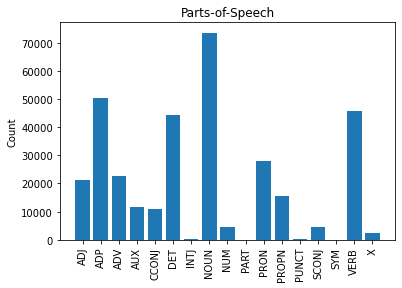

POS Tags: https://universaldependencies.org/docs/u/pos/
----
"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries


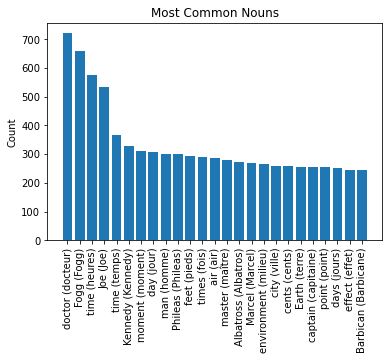

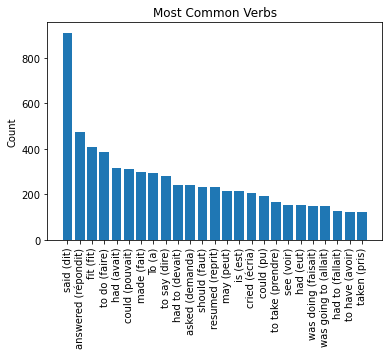

In [ ]:
# generate EDA report

corpus_eda(fr_nlp, jules_verne_texts,
           processors=cores)

##### Preprocessing

In Preprocessing, we convert our text into the bag-of-words format required by Gensim. As part of this process, we invoke our preprocessing function which tokenizes and filters our text to include terms of greatest value. Gensim creates the bag-of-words entries using a dictionary created from our sample. We use a facility in this dictionary to filter extreme values from our tokenized texts.

In [ ]:
# preprocessing parameters

preprocess_params = dict(
    texts=jules_verne_texts, 
    min_token_length=3    
)

In [ ]:
# basic preprocessing

%time jules_verne_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 282 ms, sys: 7.93 ms, total: 290 ms
Wall time: 290 ms


In [ ]:
# advanced preprocessing

%time jules_verne_docs_advanced = advanced_preprocess(fr_nlp, \
                                                      **preprocess_params, \
                                                      processors=cores)

CPU times: user 1.55 s, sys: 162 ms, total: 1.72 s
Wall time: 32 s


In [ ]:
# examine the term lengths on docs for grades of preprocessing

print(f'terms basic vs. advanced preprocessing:')
for title, basic, advanced \
 in zip(jules_verne_french_books,
        jules_verne_docs_basic,
        jules_verne_docs_advanced):
  print(f'\t{len(basic)}\tvs.\t{len(advanced)}\t({title})')

terms basic vs. advanced preprocessing:
	59713	vs.	35739	(Five_Weeks_in_a_Balloon.txt)
	51505	vs.	31310	(Around_the_World_in_Eighty_Days.txt)
	43217	vs.	25396	(Robur_the_Conqueror.txt)
	40445	vs.	24221	(From_the_Earth_to_the_Moon.txt)
	38249	vs.	23133	(The_Begums_Fortune.txt)
	13719	vs.	8389	(The_Blockade_Runners.txt)
	5348	vs.	3053	(The_Mutineers_of_the_Bounty.txt)


In [ ]:
# use advanced output for subsequent processing

jules_verne_docs = jules_verne_docs_advanced

print(len(jules_verne_docs))

7


In [ ]:
# construct dictionary from processed docs

jules_verne_dictionary = corpora.Dictionary(jules_verne_docs)

print(jules_verne_dictionary)

Dictionary(13627 unique tokens: ['abaissement', 'abaisser', 'abandonne', 'abandonner', 'abat']...)


In filtering extremes, terms that occur in too few documents or too many documents are removed. For this set of French books, terms will be allowed to occur in only one document to detect the themes of each book. Terms that occur in more than 70% of documents will be removed which may help reduce the interference of any boilerplate header text.

In [ ]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

jules_verne_dictionary.filter_extremes(no_below=1,
                                       no_above=0.7)

print(jules_verne_dictionary)

Dictionary(11553 unique tokens: ['abaissement', 'abandonne', 'abat', 'abattu', 'abbadie']...)


In [ ]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

jules_verne_corpus = [jules_verne_dictionary.doc2bow(doc)
                      for doc in jules_verne_docs]

### Topic Modeling

#### Hyperparameter Estimation

##### LDA Model Estimation

To begin, we evaluate a traditional LDA model as a benchmark.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.LdaModel,
    model_params=dict(corpus=jules_verne_corpus,
                      id2word=jules_verne_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=jules_verne_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Number of Topics

We will vary the number of topics sought by the LDA model over range sampling at intervals for efficiency.

In [ ]:
# variable parameter

eval_params['test_param'] = 'num_topics'

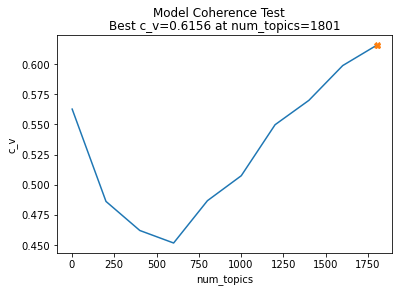

CPU times: user 902 ms, sys: 826 ms, total: 1.73 s
Wall time: 41.6 s


In [ ]:
# coarse estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=200)), \
                     **eval_params)

As seen in this plot, coherence remains in a useful range but bottoms around the sampling point near 600. Increasing the number of topics for LDA beyond that bottom point improves coherence more linearly. As our goal is dimensional reduction and the c_v metric is indicating coherent topics in the ranges observed, perhaps a starting point to explore based upon this evidence would be in the 100-200 range.

##### HDP Model Estimation

Next we evaluate an HDP model over the same data.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.HdpModel,
    model_params=dict(corpus=jules_verne_corpus,
                      id2word=jules_verne_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=jules_verne_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Max Time

Before evaluating the topic truncation parameter, we determine the effect of limiting time available to model processing.

In [ ]:
# variable parameter

eval_params['test_param'] = 'max_time'

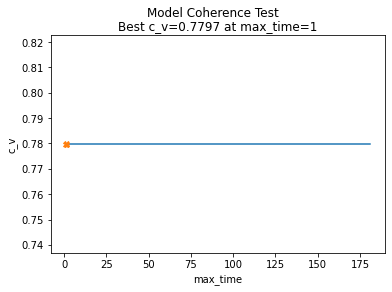

CPU times: user 665 ms, sys: 755 ms, total: 1.42 s
Wall time: 4min 6s


In [ ]:
# coarse estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=20)), \
                     **eval_params)

Given the lack of variance over maximum time allowed, it can be concluded modelling this corpus does not benefit from added time. The data sizes may be small enough to be managed below any imposed time limitations.

###### Varying Topic Truncation

Next, using the same HDP model, we can evaluate the effects of varying the topic truncation parameter. This determines how many topics the model can discover before halting.

In [ ]:
# variable parameter

eval_params['test_param'] = 'T'

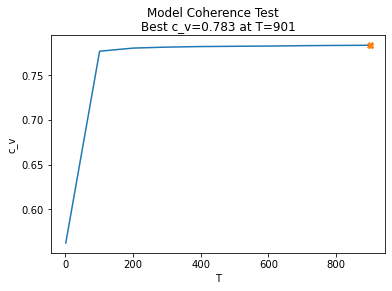

CPU times: user 1.31 s, sys: 995 ms, total: 2.31 s
Wall time: 7min 34s


In [ ]:
# coarse estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

As seen in this plot, there is a very obvious point of diminishing returns around 100 for parameter T. 

We will zoom in in this range taking higher resolution samples.

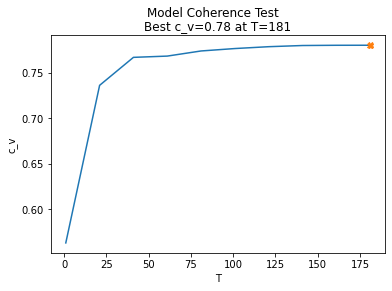

CPU times: user 575 ms, sys: 595 ms, total: 1.17 s
Wall time: 21.4 s


In [ ]:
# finer estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=20)), \
                     **eval_params)

Increasing the sampling rate in the range previously identified, we can see the point of diminishing returns occurs far before 100 seen in the lower resolution test before. The true value appears to be closer to 40.

We will zoom in in this range taking higher resolution samples.

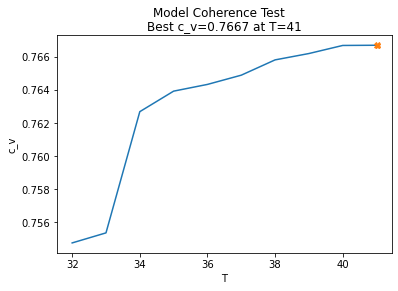

CPU times: user 484 ms, sys: 613 ms, total: 1.1 s
Wall time: 10.1 s


In [ ]:
# fine estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=32, \
                                                     steps=10, \
                                                     stride=1)), \
                     **eval_params)

At a sampling rate of 1 topic, we can see our earlier estimation may be reasonable. Around 41 topics, increases in coherence become less pronounced. We will visualize this estimate to determine what can be learned from these texts.

###### Aside: Coherence Metric Comparison

For a reference point, we compare a model using the French corpus at 41 topics using the u_mass coherence metrics versus the c_v metric used above. Our earlier good quality value near 0.77 translates into a u_mass value near -12.9. These two metrics move inversely.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.HdpModel,
    model_params=dict(corpus=jules_verne_corpus,
                      id2word=jules_verne_dictionary,
                      random_state=random_seed),
    coherence_params=dict(corpus=jules_verne_corpus),
    evaluation_function=evaluate_model,
    best_key_func=best_lowest,
    coherence='u_mass',
    processors=cores
)

In [ ]:
# variable parameter

eval_params['test_param'] = 'T'

In [ ]:
# point estimation

%time best, coherence, jules_verne_model = \
  evaluate_coherence(test_series=reversed(step_range(start=41, \
                                                     steps=1, \
                                                     stride=1)), \
                     show_plot=False, \
                     **eval_params)
  
print(f"Point Coherence: {round(coherence, 4)}")

CPU times: user 29.7 ms, sys: 101 ms, total: 130 ms
Wall time: 428 ms
Point Coherence: -12.896


### Translation

In preparation for presentation, we augment our Gensim dictionary with language translations.

In [ ]:
# create a translation of the dictionary for presentation

misses, jules_verne_xlat_dictionary = \
  translate_gensim_dictionary(jules_verne_dictionary, 'fr')
  
print(f'{misses} cache misses.')
print(jules_verne_xlat_dictionary)

"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries
0 cache misses.
Dictionary(11553 unique tokens: ['lowering (abaissement)', 'abandoned (abandonne)', 'would give up (abandonnerait)', 'abandoned (abandonnes)', 'abandoned (abandonné)']...)


### Visualization

Our model may be projected into a reduced dimensional space we can view on a two-dimensional plot. We can see our topics as bubbles in this interactive plot which also shows the terms and their contributions to the selected topic.

In [ ]:
# prepare model visualization

vis_data = gensimvis.prepare(jules_verne_model,
                             jules_verne_corpus,
                             jules_verne_xlat_dictionary,
                             mds='tsne')

/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

In [ ]:
# display the visualization inline

pyLDAvis.display(vis_data)

Of particular interest in this visualization, it appears the seven works themselves correlate to the dominant topics. Selecting each topic bubble produces a list of terms that match the primary characters and plot points of a work. Assuming this interpretation is correct, the arrangement of the bubbles indicate all works except 6 occupy a similar space and may even overlap. Topic 6 indicates the work *The Blockade Runners* may be most unlike the others. Plot summaries for these works can be studied on Wikipedia. Also note that the grouping of similar works encircles many minor topics depicted only with numbers. This may indicate additional similarity assuming the bubbles are the works' primary topics and the encircled numbers thematically similar topics.

### Clean Up

In [ ]:
del fr_nlp

## Spanish Language Samples

In this demonstration, we will examine a corpus of tens of thousands of RSS news headlines from 2019.

Original documents may be found at [Corpora Collection Leipzig University](https://corpora.uni-leipzig.de/en).

In [ ]:
# samples of the Spanish language

# samples are available within this repository

# characteristics: many, short documents taken from RSS news headlines
# with line numbers intact
spanish_news_url = ('https://raw.githubusercontent.com/jbrown544/'
                    'interlingual-topic-modeling/main/text/news/es/'
                    'spa_news_2019_30K-sentences.txt')

#### Process Spanish Language Samples

To begin, we load our language model and language samples.

In [ ]:
# load language model and inspect pipeline: Spanish

es_nlp = spacy.load('es_core_news_md', exclude=['parser', 'ner'])

print("Pipeline:", es_nlp.pipe_names)

Pipeline: ['tok2vec', 'morphologizer', 'attribute_ruler', 'lemmatizer']


In [ ]:
# load encoded Spanish news headlines

spanish_news_texts = []

with open(spanish_news_url, encoding='utf-8') as f:
  spanish_news_texts = f.readlines()

##### EDA Report

We examine our corpus using the ```corpus_eda()``` function.

EDA Report
----
Document count: 30,000
POS count: 16
Sentence count: 58,768
Token count: 860,668
Word count: 669,628
Unique Word count: 54,132
----
Avg. Tokens/Sentence: 14.65
Avg. Words/Sentence: 11.39
Avg. Tokens/Document: 28.69
Avg. Words/Document: 22.32
Avg. Sentences/Document: 1.96
----


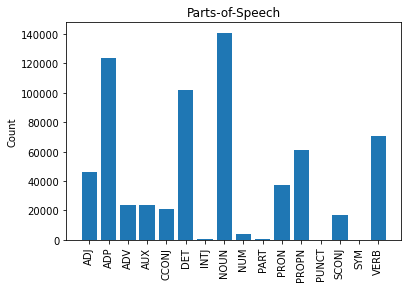

POS Tags: https://universaldependencies.org/docs/u/pos/
----
"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries


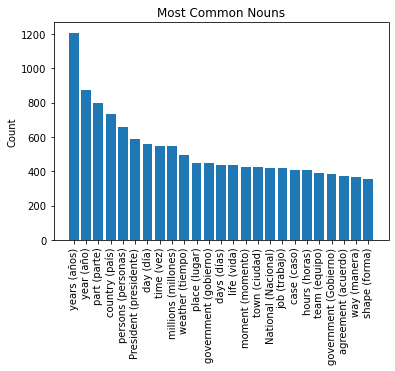

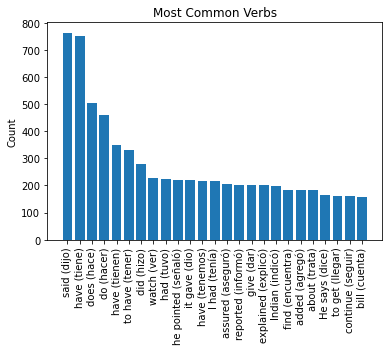

In [ ]:
# generate EDA report

corpus_eda(es_nlp, spanish_news_texts,
           processors=cores)

##### Preprocessing

In Preprocessing, we convert our text into the bag-of-words format required by Gensim. As part of this process, we invoke our preprocessing function which tokenizes and filters our text to include terms of greatest value. Gensim creates the bag-of-words entries using a dictionary created from our sample. We use a facility in this dictionary to filter extreme values from our tokenized texts.

In [ ]:
# preprocessing parameters

preprocess_params = dict(
    texts=spanish_news_texts, 
    min_token_length=3    
)

In [ ]:
# basic preprocessing

%time spanish_news_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 610 ms, sys: 8.21 ms, total: 619 ms
Wall time: 618 ms


In [ ]:
# advanced preprocessing

%time spanish_news_docs_advanced = advanced_preprocess(es_nlp, \
                                                       **preprocess_params, \
                                                       processors=cores)

CPU times: user 14 s, sys: 247 ms, total: 14.3 s
Wall time: 15.9 s


In [ ]:
# examine the term lengths on docs for grades of preprocessing

print(f'terms basic vs. advanced preprocessing:')
for  i, (basic, advanced) \
 in enumerate(zip(spanish_news_docs_basic[:10], 
                  spanish_news_docs_advanced[:10])):
    print(f'\t{len(basic)}\tvs.\t{len(advanced)}\t(Line {i+1})')

terms basic vs. advanced preprocessing:
	32	vs.	18	(Line 1)
	10	vs.	3	(Line 2)
	9	vs.	6	(Line 3)
	6	vs.	5	(Line 4)
	31	vs.	15	(Line 5)
	14	vs.	14	(Line 6)
	9	vs.	5	(Line 7)
	20	vs.	9	(Line 8)
	9	vs.	6	(Line 9)
	17	vs.	14	(Line 10)


This filtering documents at a minimum size was added to prevent a calculation error in Gensim that appeared to occur when some documents were filtered to zero length.

In [ ]:
# use advanced output for subsequent processing 

# eliminate documents which were parsed into too few tokens
spanish_news_docs = [doc for doc in spanish_news_docs_advanced 
                     if len(doc) > 4]

print(len(spanish_news_docs))

25597


In [ ]:
# construct dictionary from processed docs

spanish_news_dictionary = corpora.Dictionary(spanish_news_docs)

print(spanish_news_dictionary)

Dictionary(33544 unique tokens: ['actor', 'asimismo', 'cable', 'canal', 'chico']...)


In filtering extremes, terms that occur in too few documents or too many documents are removed. For this set of news headlines, terms must occur in at least three headlines. Terms that occur in over 20% of headlines are removed. These parameters produced a manageable number of terms comparable to the earlier successful visualizations.

In [ ]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

spanish_news_dictionary.filter_extremes(no_below=3,
                                        no_above=0.2)

print(spanish_news_dictionary)

Dictionary(10942 unique tokens: ['actor', 'asimismo', 'cable', 'canal', 'chico']...)


In [ ]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

spanish_news_corpus = [spanish_news_dictionary.doc2bow(doc)
                       for doc in spanish_news_docs]

### Topic Modeling

#### Hyperparameter Estimation

##### LDA Model Estimation

To begin, we evaluate a traditional LDA model as a benchmark.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.LdaModel,
    model_params=dict(corpus=spanish_news_corpus,
                      id2word=spanish_news_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=spanish_news_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Number of Topics

We will vary the number of topics sought by the LDA model over range sampling at intervals for efficiency.

In [ ]:
# variable parameter

eval_params['test_param'] = 'num_topics'

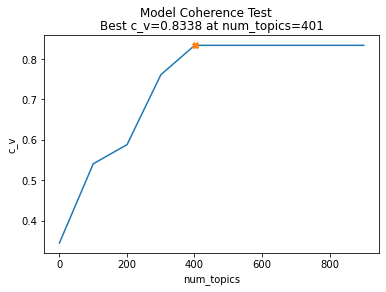

CPU times: user 1.41 s, sys: 579 ms, total: 1.99 s
Wall time: 1min 28s


In [ ]:
# coarse estimation

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

Though the sampling rate here is making strides of 100 topics per movement, there appears to be a distinct change in improvement somewhere around 400 topics. For c_v scores this and even several of the lower scores appear higher than normal so perhaps the slight plateau in the 100-200 topic range might be of interest.

##### HDP Model Estimation

Next we evaluate an HDP model over the same data.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.HdpModel,
    model_params=dict(corpus=spanish_news_corpus,                      
                      id2word=spanish_news_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=spanish_news_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Max Time

Before evaluating the topic truncation parameter, we determine the effect of limiting time available to model processing.

In [ ]:
# variable parameter

eval_params['test_param'] = 'max_time'

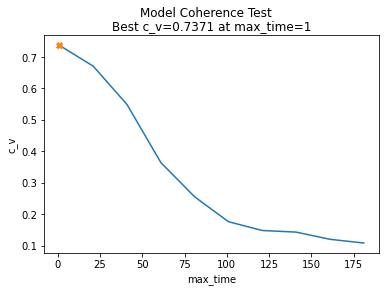

CPU times: user 2.41 s, sys: 800 ms, total: 3.21 s
Wall time: 3min 23s


In [ ]:
# coarse estimation

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=20)), \
                     **eval_params)

Interestingly here we can see around 100 seconds using the default of 150 T (topic truncation), the deterioration in coherence begins to subside. With limited time, this model produces highly coherent topics, but with additional analysis it may be arriving at a conclusion the corpus is less coherent than it seemed with less superficial analysis.

###### Varying Topic Truncation

Next, using the same HDP model, we can evaluate the effects of varying the topic truncation parameter. This determines how many topics the model can discover before halting.

In [ ]:
# variable parameter

eval_params['test_param'] = 'T'

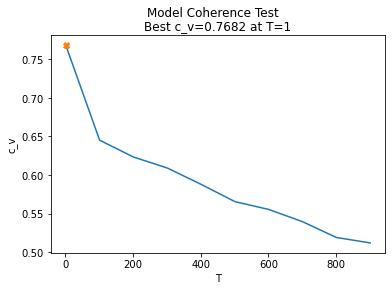

CPU times: user 3.47 s, sys: 1.14 s, total: 4.61 s
Wall time: 7min 46s


In [ ]:
# coarse estimation #1

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

From our earlier experiment varying the maximum time allowed for processing, we will impose a maximum processing time of 100 seconds per model.

In [ ]:
# value estimated from earlier parameter search

eval_params['model_params']['max_time'] = 100

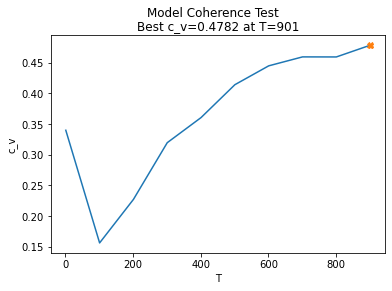

CPU times: user 3.09 s, sys: 1.07 s, total: 4.16 s
Wall time: 7min 47s


In [ ]:
# coarse estimation #2

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

Comparing this plot to the one immediately before it, we can see the imposition of a time constraint changes the outcome pattern notably. The coherence values are now below the worst of the prior plot but showing gradual improvement as topics are increased. Attempting to limit processing time did not improve run times either as both were around 7 minutes and 45 seconds. Therefore this time limitation will be removed.

In [ ]:
# remove parameter

del eval_params['model_params']['max_time']

Returning to analyzing T values, we will zoom in on the left section of the earlier plot taking higher resolution samples.

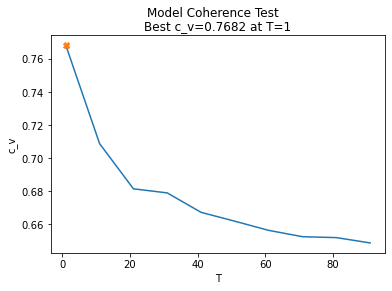

CPU times: user 2.15 s, sys: 694 ms, total: 2.84 s
Wall time: 55 s


In [ ]:
# finer estimation

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=10)), \
                     **eval_params)

We observe much the same descending pattern as in the original HDP evaluation, though there does appear to be a small elbow around 20-30 T. This also places our c_v scores in a reasonable range above poor but below extremely high scores with relatively few topics for such a diverse corpus.

We will further zoom in taking higher resolution samples.

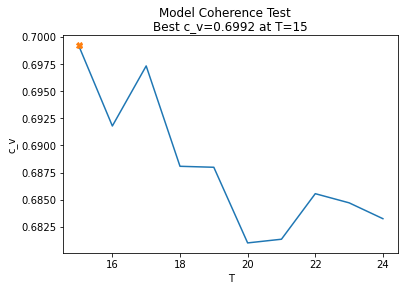

CPU times: user 2.27 s, sys: 689 ms, total: 2.95 s
Wall time: 52.4 s


In [ ]:
# finer estimation

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=15, \
                                                     steps=10, \
                                                     stride=1)), \
                     **eval_params)

Here we see a slight bounce around 20 T possibly indicating that our descent from too few topics which achieve unusually high coherence reverses momentarily.

Since 22 was not the optimum point in our evaluation, we will do a point evaluation on 22 to observe a topic model at this value of T.

In [ ]:
# point estimation

%time best, coherence, spanish_news_model = \
  evaluate_coherence(test_series=reversed(step_range(start=22, \
                                                     steps=1, \
                                                     stride=1)), \
                     show_plot=False, \
                     **eval_params)
  
print(f"Point Coherence: {round(coherence, 4)}")

CPU times: user 137 ms, sys: 140 ms, total: 277 ms
Wall time: 23.2 s
Point Coherence: 0.6855


### Translation

In preparation for presentation, we augment our Gensim dictionary with language translations.

In [ ]:
# create a translation of the dictionary for presentation

misses, spanish_news_xlat_dictionary = \
  translate_gensim_dictionary(spanish_news_dictionary, 'es')
  
print(f'{misses} cache misses.')
print(spanish_news_xlat_dictionary)

"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries
0 cache misses.
Dictionary(10942 unique tokens: ['aaron (aaron)', 'down (abajo)', 'pounce (abalanzar)', 'standard bearer (abanderado)', 'abandoned (abandonado)']...)


### Visualization

Our model may be projected into a reduced dimensional space we can view on a two-dimensional plot. We can see our topics as bubbles in this interactive plot which also shows the terms and their contributions to the selected topic.

In [ ]:
# prepare model visualization

vis_data = gensimvis.prepare(spanish_news_model,
                             spanish_news_corpus,
                             spanish_news_xlat_dictionary,
                             mds='tsne')

/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

In [ ]:
# display the visualization inline

pyLDAvis.display(vis_data)

Interestingly with our estimate of 22 topics, a visualization produces fairly uniform topic sizes in the bubbles with even dispersion. With tens of thousands of headlines reduced to only 22 topics, these topics are likely to include concepts that may appear quite unrelated in human interpretation. For example, adjusting the relevance slider to 0.5 for an even mix of term frequency and term relevance, we can observe terms in topic 8 including thunberg (Greta Thunberg?), greenpeace, censorship, newspapers, Francoism, and pinochet (Augusto Pinochet?). Exploring the topics in this corpora is not as simple as the earlier French example where 7 long written works clearly subdivided the visualization space.

To further explore this space, there were many other promising T values with good coherence scores along the earlier plot to 800 T. 

### Clean Up

In [ ]:
del es_nlp

## English-Polish Parallel Language Samples

In this demonstration, we will examine a parallel corpus devised from proceedings of the European parliament 1996-2011. This pair contains statements in English and Polish collected and aligned for use in statistical machine translation systems. Since our search for latent topics across languages is a form of compressed translation, this language pair may demonstrate how topic modelling performs on semantically identical text in multiple languages.

In this sample from [Europarl](http://www.statmt.org/europarl/) (Koehn, 2005), the first 150K lines were taken from the parallel corpus to stay within file limits of file sizes imposed by Github. To ensure the two texts were cut at the same point, the final sentence of each truncated file is compared here:
* *That would be more intelligent, healthier, safer and greener.* (English)
* *To byłoby rozwiązaniem bardziej inteligentnym, zdrowszym, bezpieczniejszym i bardziej przyjaznym środowisku.* (Polish)
  * *This would be a smarter, healthier, safer and more environmentally friendly solution.* (Google Translated Polish)

In [ ]:
# parallel samples of the English and Polish languages

# samples are available within this repository

# characteristics: many, short samples from 
# the proceedings of the European Parliament

english_europarl_url = ('https://raw.githubusercontent.com/jbrown544/'
                        'interlingual-topic-modeling/main/text/gov/multi/'
                        'europarl-v7.pl-en.en.150k')

polish_europarl_url = ('https://raw.githubusercontent.com/jbrown544/'
                       'interlingual-topic-modeling/main/text/gov/multi/'
                       'europarl-v7.pl-en.pl.150k')


#### Process Parallel Language Samples

To begin, we load our language model and language samples.

In [ ]:
# load language model and inspect pipeline: English

en_nlp = spacy.load('en_core_web_md', exclude=['parser', 'ner'])

print("English Pipeline:", en_nlp.pipe_names)

# load language model and inspect pipeline: Polish

pl_nlp = spacy.load('pl_core_news_md', exclude=['parser', 'ner'])

print("Polish Pipeline:", pl_nlp.pipe_names)

English Pipeline: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']
Polish Pipeline: ['tok2vec', 'morphologizer', 'tagger', 'attribute_ruler', 'lemmatizer']


In [ ]:
# load encoded proceedings: English

english_europarl_texts = []

with open(english_europarl_url, encoding='utf-8') as f:
  english_europarl_texts = f.readlines()
  
# load encoded proceedings: Polish

polish_europarl_texts = []

with open(polish_europarl_url, encoding='utf-8') as f:
  polish_europarl_texts = f.readlines()

##### EDA Reports

We examine our corpus using the ```corpus_eda()``` function.

EDA Report
----
Document count: 150,000
POS count: 15
Sentence count: 200,287
Token count: 4,119,913
Word count: 3,509,689
Unique Word count: 34,083
----
Avg. Tokens/Sentence: 20.57
Avg. Words/Sentence: 17.52
Avg. Tokens/Document: 27.47
Avg. Words/Document: 23.4
Avg. Sentences/Document: 1.34
----


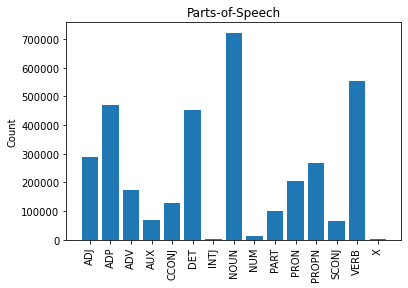

POS Tags: https://universaldependencies.org/docs/u/pos/
----


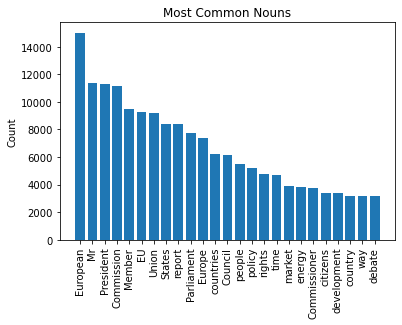

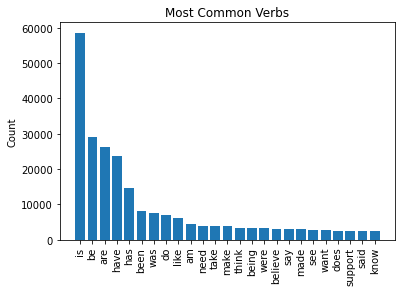

In [ ]:
# generate EDA report: English

corpus_eda(en_nlp, english_europarl_texts,
           processors=cores)

EDA Report
----
Document count: 150,000
POS count: 17
Sentence count: 304,388
Token count: 3,581,908
Word count: 2,928,209
Unique Word count: 102,810
----
Avg. Tokens/Sentence: 11.77
Avg. Words/Sentence: 9.62
Avg. Tokens/Document: 23.88
Avg. Words/Document: 19.52
Avg. Sentences/Document: 2.03
----


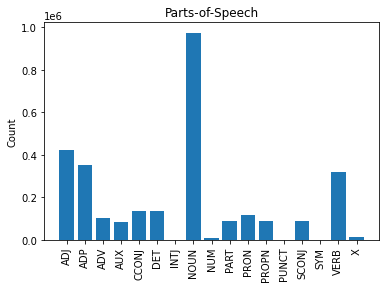

POS Tags: https://universaldependencies.org/docs/u/pos/
----
"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries


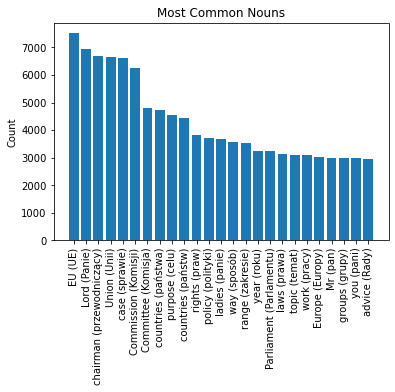

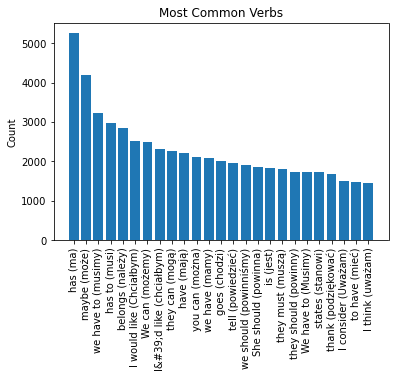

In [ ]:
# generate EDA report: Polish

corpus_eda(pl_nlp, polish_europarl_texts,
           processors=cores)

##### Preprocessing: English

In Preprocessing, we convert our text into the bag-of-words format required by Gensim. As part of this process, we invoke our preprocessing function which tokenizes and filters our text to include terms of greatest value. Gensim creates the bag-of-words entries using a dictionary created from our sample. We use a facility in this dictionary to filter extreme values from our tokenized texts.

In [ ]:
# preprocessing parameters

preprocess_params = dict(
    texts=english_europarl_texts, 
    min_token_length=3    
)

In [ ]:
# basic preprocessing

%time english_europarl_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 3.39 s, sys: 51.1 ms, total: 3.44 s
Wall time: 3.45 s


In [ ]:
# advanced preprocessing

%time english_europarl_docs_advanced = advanced_preprocess(en_nlp, \
                                                           **preprocess_params, \
                                                           processors=cores)

CPU times: user 1min 7s, sys: 1.19 s, total: 1min 8s
Wall time: 1min 10s


In [ ]:
# examine the term lengths on docs for grades of preprocessing

# observe the last 10 lines

print(f'terms basic vs. advanced preprocessing:')
for  i, (basic, advanced) \
 in enumerate(zip(english_europarl_docs_basic[-10:], 
                  english_europarl_docs_advanced[-10:])):
    print(f'\t{len(basic)}\tvs.\t{len(advanced)}'
          f'\t(Line {i+(len(english_europarl_docs_basic)-10)+1})')

terms basic vs. advanced preprocessing:
	8	vs.	5	(Line 149991)
	13	vs.	9	(Line 149992)
	41	vs.	25	(Line 149993)
	11	vs.	7	(Line 149994)
	15	vs.	8	(Line 149995)
	10	vs.	5	(Line 149996)
	15	vs.	7	(Line 149997)
	13	vs.	8	(Line 149998)
	14	vs.	12	(Line 149999)
	8	vs.	4	(Line 150000)


This filtering documents at a minimum size was added to prevent a calculation error in Gensim that appeared to occur when some documents were filtered to zero length.

In [ ]:
# use advanced output for subsequent processing

english_europarl_docs = [doc for doc in english_europarl_docs_advanced
                         if len(doc) > 5]

print(len(english_europarl_docs))

114567


In [ ]:
# construct dictionary from processed docs

english_europarl_dictionary = corpora.Dictionary(english_europarl_docs)

print(english_europarl_dictionary)

Dictionary(22087 unique tokens: ['action', 'field', 'future', 'minutes', 'motion']...)


In filtering extremes, terms that occur in too few documents or too many documents are removed. For this set of parliamentary proceedings, terms must occur in at least three translations. Terms that occur in over 20% of translations are removed. These parameters produced a manageable number of terms comparable to the earlier successful visualizations.

In [ ]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

english_europarl_dictionary.filter_extremes(no_below=3,
                                            no_above=0.2)

print(english_europarl_dictionary)

Dictionary(11978 unique tokens: ['action', 'field', 'future', 'minutes', 'motion']...)


In [ ]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

english_europarl_corpus = [english_europarl_dictionary.doc2bow(doc)
                           for doc in english_europarl_docs]

##### Preprocessing: Polish

In [ ]:
# preprocessing parameters

preprocess_params = dict(
    texts=polish_europarl_texts, 
    min_token_length=3    
)

In [ ]:
# basic preprocessing

%time polish_europarl_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 3.61 s, sys: 55.5 ms, total: 3.67 s
Wall time: 3.67 s


In [ ]:
# advanced preprocessing

%time polish_europarl_docs_advanced = advanced_preprocess(pl_nlp, \
                                                          **preprocess_params, \
                                                          processors=cores)

CPU times: user 1min 13s, sys: 1.27 s, total: 1min 14s
Wall time: 1min 36s


In [ ]:
# examine the term lengths on docs for grades of preprocessing

# observe the last 10 lines

print(f'terms basic vs. advanced preprocessing:')
for  i, (basic, advanced) \
 in enumerate(zip(polish_europarl_docs_basic[-10:], 
                  polish_europarl_docs_advanced[-10:])):
    print(f'\t{len(basic)}\tvs.\t{len(advanced)}'
          f'\t(Line {i+(len(polish_europarl_docs_advanced)-10)+1})')

terms basic vs. advanced preprocessing:
	9	vs.	5	(Line 149991)
	19	vs.	11	(Line 149992)
	35	vs.	25	(Line 149993)
	11	vs.	9	(Line 149994)
	13	vs.	8	(Line 149995)
	8	vs.	7	(Line 149996)
	12	vs.	10	(Line 149997)
	15	vs.	10	(Line 149998)
	17	vs.	16	(Line 149999)
	8	vs.	6	(Line 150000)


This filtering documents at a minimum size was added to prevent a calculation error in Gensim that appeared to occur when some documents were filtered to zero length.

In [ ]:
# use advanced output for subsequent processing

polish_europarl_docs = [doc for doc in polish_europarl_docs_advanced
                        if len(doc) > 5]

print(len(polish_europarl_docs))

121577


In [ ]:
# construct dictionary from processed docs

polish_europarl_dictionary = corpora.Dictionary(polish_europarl_docs)

print(polish_europarl_dictionary)

Dictionary(40405 unique tokens: ['działanie', 'parlament', 'patrzyć', 'podjęte', 'protokól']...)


An interesting observation here is Polish tokenization resulted in almost twice as many terms.

In filtering extremes, terms that occur in too few documents or too many documents are removed. For this set of parliamentary proceedings, terms must occur in at least three translations. Terms that occur in over 20% of translations are removed. These parameters were adjusted to maintain around the same number of terms as the English parallel sample.

In [ ]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

polish_europarl_dictionary.filter_extremes(no_below=3,
                                           no_above=0.2)

print(polish_europarl_dictionary)

Dictionary(18753 unique tokens: ['działanie', 'parlament', 'patrzyć', 'podjęte', 'protokól']...)


In [ ]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

polish_europarl_corpus = [polish_europarl_dictionary.doc2bow(doc)
                          for doc in polish_europarl_docs]

### Topic Modeling

#### Hyperparameter Estimation: English

##### HDP Model Estimation

In the case of our parallel corpus, we perform HDP first as a benchmark as the LDA results proved far more interesting.

We switch to the much faster u_mass metric in this case to reduce processing overhead associated with the c_v metric.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.HdpModel,
    model_params=dict(corpus=english_europarl_corpus,                      
                      id2word=english_europarl_dictionary,
                      random_state=random_seed),
    coherence_params=dict(corpus=english_europarl_corpus),
    evaluation_function=evaluate_model,
    best_key_func=best_lowest,
    coherence='u_mass',
    processors=cores
)

###### Varying Topic Truncation

Using an HDP model, we can evaluate the effects of varying the topic truncation parameter. This determines how many topics the model can discover before halting.

In [ ]:
# variable parameter

eval_params['test_param'] = 'T'

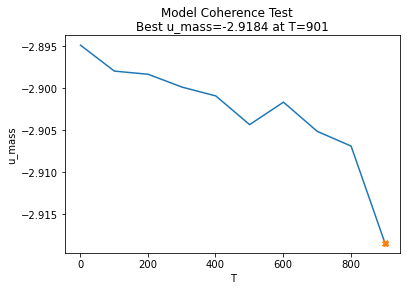

CPU times: user 10.1 s, sys: 2.11 s, total: 12.2 s
Wall time: 17min 8s


In [ ]:
# coarse estimation

%time best, coherence, english_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

In this plot it appears none of the sampled T values produced coherences particularly interesting.

##### LDA Model Estimation

We evaluate a traditional LDA model for analysis given the HDP model did not produce interesting coherence values.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.LdaModel,
    model_params=dict(corpus=english_europarl_corpus,
                      id2word=english_europarl_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=english_europarl_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Number of Topics

We will vary the number of topics sought by the LDA model over a range sampling at intervals for efficiency.

In [ ]:
# variable parameter

eval_params['test_param'] = 'num_topics'

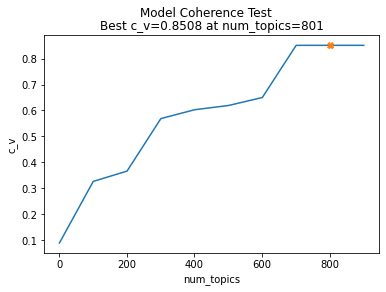

CPU times: user 6.85 s, sys: 1.18 s, total: 8.02 s
Wall time: 7min 1s


In [ ]:
# coarse estimation

%time best, coherence, english_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

Here we see coherence values approaching perfect at over 600 topics which is usually unrealistic, but well before then we see coherence values passing through scores more indicative of usually reasonable models (0.5-0.7) between 250 and 700 topics.

###### Point Estimation

Given visualization of hundreds of topics can be a challenge, we will take a point sample at the lower end of the indicated range from above at 250 topics.

In [ ]:
# point estimation

%time best, coherence, english_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=250, \
                                                     steps=1, \
                                                     stride=1)), \
                     show_plot=False, \
                     **eval_params)
  
print(f"Point Coherence: {round(coherence, 4)}")

CPU times: user 644 ms, sys: 337 ms, total: 981 ms
Wall time: 52.3 s
Point Coherence: 0.5096


#### Hyperparameter Estimation: Polish

##### HDP Model Estimation

In the case of our parallel corpus, we perform HDP first as a benchmark as the LDA results proved far more interesting.

We switch to the much faster u_mass metric in this case to reduce processing overhead associated with the c_v metric.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.HdpModel,
    model_params=dict(corpus=polish_europarl_corpus,                      
                      id2word=polish_europarl_dictionary,
                      random_state=random_seed),
    coherence_params=dict(corpus=polish_europarl_corpus),
    evaluation_function=evaluate_model,
    best_key_func=best_lowest,
    coherence='u_mass',
    processors=cores
)

###### Varying Topic Truncation

Using an HDP model, we can evaluate the effects of varying the topic truncation parameter. This determines how many topics the model can discover before halting.

In [ ]:
# variable parameter

eval_params['test_param'] = 'T'

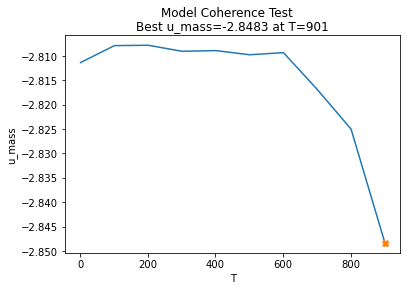

CPU times: user 10.1 s, sys: 2.37 s, total: 12.4 s
Wall time: 21min 45s


In [ ]:
# coarse estimation

%time best, coherence, polish_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

In this plot it appears none of the sampled T values produced coherences particularly interesting.

##### LDA Model Estimation

We evaluate a traditional LDA model for analysis given the HDP model did not produce interesting coherence values.

In [ ]:
# model evaluation parameters

eval_params = dict(
    model_class=models.LdaModel,
    model_params=dict(corpus=polish_europarl_corpus,
                      id2word=polish_europarl_dictionary,
                      random_state=random_seed),
    coherence_params=dict(texts=polish_europarl_docs),
    evaluation_function=evaluate_model,
    best_key_func=best_nearest_one,
    coherence='c_v',
    processors=cores
)

###### Varying Number of Topics

We will vary the number of topics sought by the LDA model over a range sampling at intervals for efficiency.

In [ ]:
# variable parameter

eval_params['test_param'] = 'num_topics'

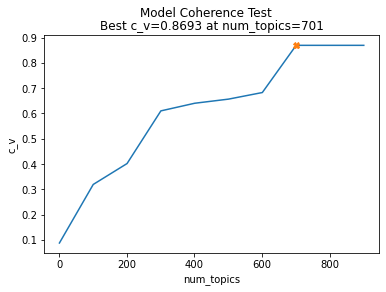

CPU times: user 8.49 s, sys: 1.63 s, total: 10.1 s
Wall time: 8min 45s


In [ ]:
# coarse estimation

%time best, coherence, polish_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=1, \
                                                     steps=10, \
                                                     stride=100)), \
                     **eval_params)

It is very interesting how much this plot resembles the earlier plot for the parallel English sample Even the optimal value suggested is similar. Given the plots follow the same trends so closely, we will model a point sample at the exact point as before.

###### Point Estimation

As described above, we are taking a sample point at 250 topics given our Polish plot resembled our English plot for topics vs coherence. This may provide a very interesting visualization given this language set is parallel containing the same semantic meaning in two languages.

In [ ]:
# point estimation

%time best, coherence, polish_europarl_model = \
  evaluate_coherence(test_series=reversed(step_range(start=250, \
                                                     steps=1, \
                                                     stride=1)), \
                     show_plot=False, \
                     **eval_params)
  
print(f"Point Coherence: {round(coherence, 4)}")

CPU times: user 714 ms, sys: 385 ms, total: 1.1 s
Wall time: 1min 3s
Point Coherence: 0.5262


### Translation

In preparation for presentation, we augment our Gensim dictionary with language translations.

We do not augment the English dictionary as that is the language in use in this presentation, but if an observer is not fluent in English then the presentation language can be modified as appropriate. The source and target languages are configurable.

In [ ]:
# create a translation of the dictionary for presentation

misses, polish_europarl_xlat_dictionary = \
  translate_gensim_dictionary(polish_europarl_dictionary, 'pl')
  
print(f'{misses} cache misses.')
print(polish_europarl_xlat_dictionary)

"caches/xlat.json" xlat cache loaded:
	[fr->en] contains 16735 entries
	[es->en] contains 34889 entries
	[pl->en] contains 41352 entries
0 cache misses.
Dictionary(18753 unique tokens: ['aal (aal)', 'aarhus (aarhus)', 'abbas (abbasa)', 'abbas (abbasem)', 'Abkhazian (abchaski)']...)


### Visualization

Our model may be projected into a reduced dimensional space we can view on a two-dimensional plot. We can see our topics as bubbles in this interactive plot which also shows the terms and their contributions to the selected topic.

In [ ]:
# prepare model visualization: English

vis_data = gensimvis.prepare(english_europarl_model,
                             english_europarl_corpus,
                             english_europarl_dictionary,
                             mds='tsne')

/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

In [ ]:
# display the visualization inline

pyLDAvis.display(vis_data)

In [ ]:
# prepare model visualization: Polish

vis_data = gensimvis.prepare(polish_europarl_model,
                             polish_europarl_corpus,
                             polish_europarl_xlat_dictionary,
                             mds='tsne')

In [ ]:
# display the visualization inline

pyLDAvis.display(vis_data)

These plots are visualizing models of a parallel set of translated documents from Polish and English. The similarity in patterns is striking with both showing an island in a top quadrant with satellites trending off toward the opposite corners of the visual. In both cases, the concentric circles in the islands are bordered by a barrier on the side trending away

### Clean Up

In [ ]:
del en_nlp, pl_nlp

##[Project References](https://github.com/jbrown544/interlingual-topic-modeling/blob/main/REFERENCES.md)